### 1. Introduction

The project aims to develop a machine learning model that predicts rice yield using rainfall data from a specific region and season, utilizing historical data for training and validation.


Imagine the power of predicting rice yield – the staple food for over half the world – based on something as simple as rainfall data. This project delves into that very possibility, aiming to develop a machine learning model that empowers farmers in a specific region and season to optimize their yields and navigate challenges.

Harnessing the wisdom of past harvests, we'll analyze historical data on rainfall patterns and rice yields, meticulously preparing it for the keen eyes of advanced algorithms. Linear regression, random forests, even deep learning techniques – we'll explore them all, seeking the perfect fit to unveil the hidden relationships between rain and rice.

Think of it as a personalized weather forecast for your crops. Our model will translate rainfall patterns into accurate yield predictions, guiding farmers towards informed decisions on planting dates, resource allocation, and even risk management. Imagine fields buzzing with optimized irrigation, fertilizers applied with surgical precision, and farmers facing the future with newfound confidence.

The impact ripples outwards. Food security bolstered, resource use minimized, and resilience against uncertain weather woven into the very fabric of agricultural practices. This isn't just about predicting rice yield; it's about empowering farmers, revolutionizing agriculture, and ultimately, safeguarding the plates of millions.

### 2. Import Libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from scipy.stats.mstats import winsorize
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb



folds  = 5
warnings.filterwarnings("ignore", category=FutureWarning)
score_calc = 'neg_mean_squared_error'

ModuleNotFoundError: No module named 'pandas'

### 3. Data Loading

In [2]:
df = pd.read_csv('crop.csv')
df.head(3)

,state_name,district_name,year,season,area,production,rainfall,temperature,humidity,sun_hours
0,Bihar,ARARIA,1997,Autumn,17876.0,21397.0,1303.7,27.5,82.0,8.3
1,Bihar,ARARIA,1997,Summer,8479.0,13993.0,1303.7,21.3,69.0,9.1
2,Bihar,ARARIA,1997,Winter,93975.0,121063.0,1303.7,21.3,69.0,9.1


#### 3.1. Data Description

* **State_Name**: This refers to the name of the state in India where the crop is being cultivated. Each state has its own unique climate, soil conditions, and agricultural practices, which can affect the type and yield of crops grown in the area.

* **District_Name**: This refers to the name of the district within a state where the crop is being cultivated. Districts within a state can have varying climate conditions, soil types, and agricultural practices, which can also affect the type and yield of crops grown in the area.

* **Crop_Year**: This refers to the year when the crop was seeded. It is important to track the crop year to understand the seasonality of crop cultivation and its impact on production.

* **Season**: This refers to the season during which the crop is cultivated. In India, there are three rice-growing seasons: autumn, winter (Kharif), and summer. Each season has its own unique climate, soil conditions, and agricultural practices, which can affect the type and yield of crops grown in the area.

* **Crop**: This refers to the specific crop that is being cultivated. In this case, it is rice, which is a crucial crop in India's agriculture sector.

* **Area**: This refers to the amount of land allocated to the crop. It is important to track the area under cultivation to understand the scale of crop production and its impact on overall agricultural production.

* **Production**: This refers to the amount of crop produced. It is crucial to track the production levels to understand the efficiency of crop cultivation and its impact on food security and the agricultural economy.

* **Rainfall**: This refers to the number of rainfall events in a specific region during a specific crop year. Rainfall is a critical factor in rice cultivation, as rice is a rain-fed crop and requires heavy annual rainfall for optimal growth

#### 3.2. Understanding Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   state_name     4898 non-null   object 
 1   district_name  4898 non-null   object 
 2   year           4898 non-null   int64  
 3   season         4898 non-null   object 
 4   area           4898 non-null   float64
 5   production     4888 non-null   float64
 6   rainfall       4898 non-null   float64
 7   temperature    4735 non-null   float64
 8   humidity       4832 non-null   float64
 9   sun_hours      4851 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 382.8+ KB


In [4]:
df.describe()

,year,area,production,rainfall,temperature,humidity,sun_hours
count,4898.000000,4898.000000,4.888000e+03,4898.000000,4735.00000,4832.000000,4851.000000
mean,2006.128011,54764.536403,1.026197e+05,1456.455921,25.68196,72.185488,8.978141
std,4.988628,77618.863274,1.833404e+05,671.382936,4.42111,8.466944,0.495374
min,1997.000000,1.000000,1.000000e+00,274.700000,16.40000,0.000000,7.800000
25%,2002.000000,2972.800000,4.823250e+03,1097.100000,21.60000,66.900000,8.600000
50%,2006.000000,20471.500000,2.598450e+04,1303.700000,26.30000,69.800000,9.100000
75%,2010.000000,81385.500000,1.191825e+05,1564.700000,28.50000,79.800000,9.300000
max,2015.000000,687000.000000,1.710000e+06,3489.600000,36.40000,94.200000,10.100000


In [5]:
df.describe(include = 'object')

,state_name,district_name,season
count,4898,4898,4898
unique,9,179,6
top,Bihar,SUPAUL,Kharif
freq,1602,53,1342


In [6]:
df.isnull().sum()

state_name         0
district_name      0
year               0
season             0
area               0
production        10
rainfall           0
temperature      163
humidity          66
sun_hours         47
dtype: int64

In [7]:
print('Duplicated rows: ', df.duplicated().sum())

Duplicated rows:  0


<AxesSubplot:>

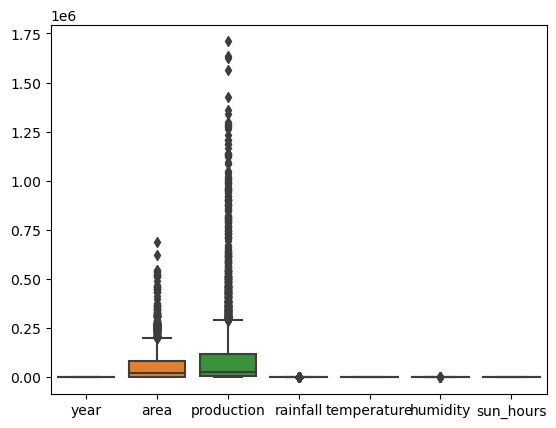

In [8]:
sns.boxplot(df)

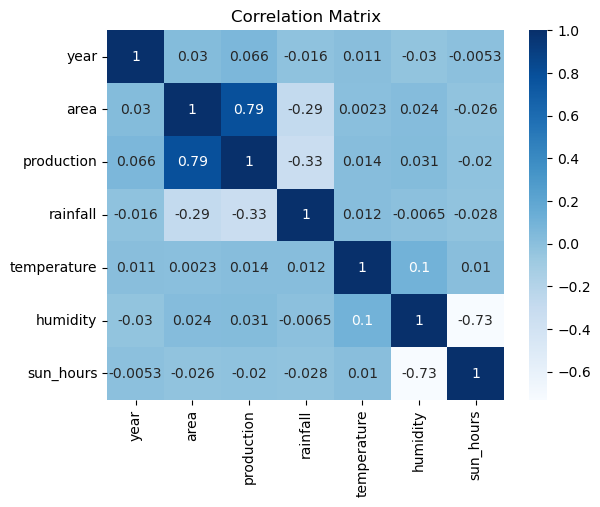

In [9]:
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.title('Correlation Matrix');

In [10]:
numerical_features = df.select_dtypes(exclude = ['object']).columns.tolist()
print(f'The numerical features: {numerical_features}')

The numerical features: ['year', 'area', 'production', 'rainfall', 'temperature', 'humidity', 'sun_hours']


In [11]:
categorical_features = df.select_dtypes(include = ['object']).columns.tolist()
print(f'The categorical features: {categorical_features}')

The categorical features: ['state_name', 'district_name', 'season']


### 4. Exploratory Data Analysis

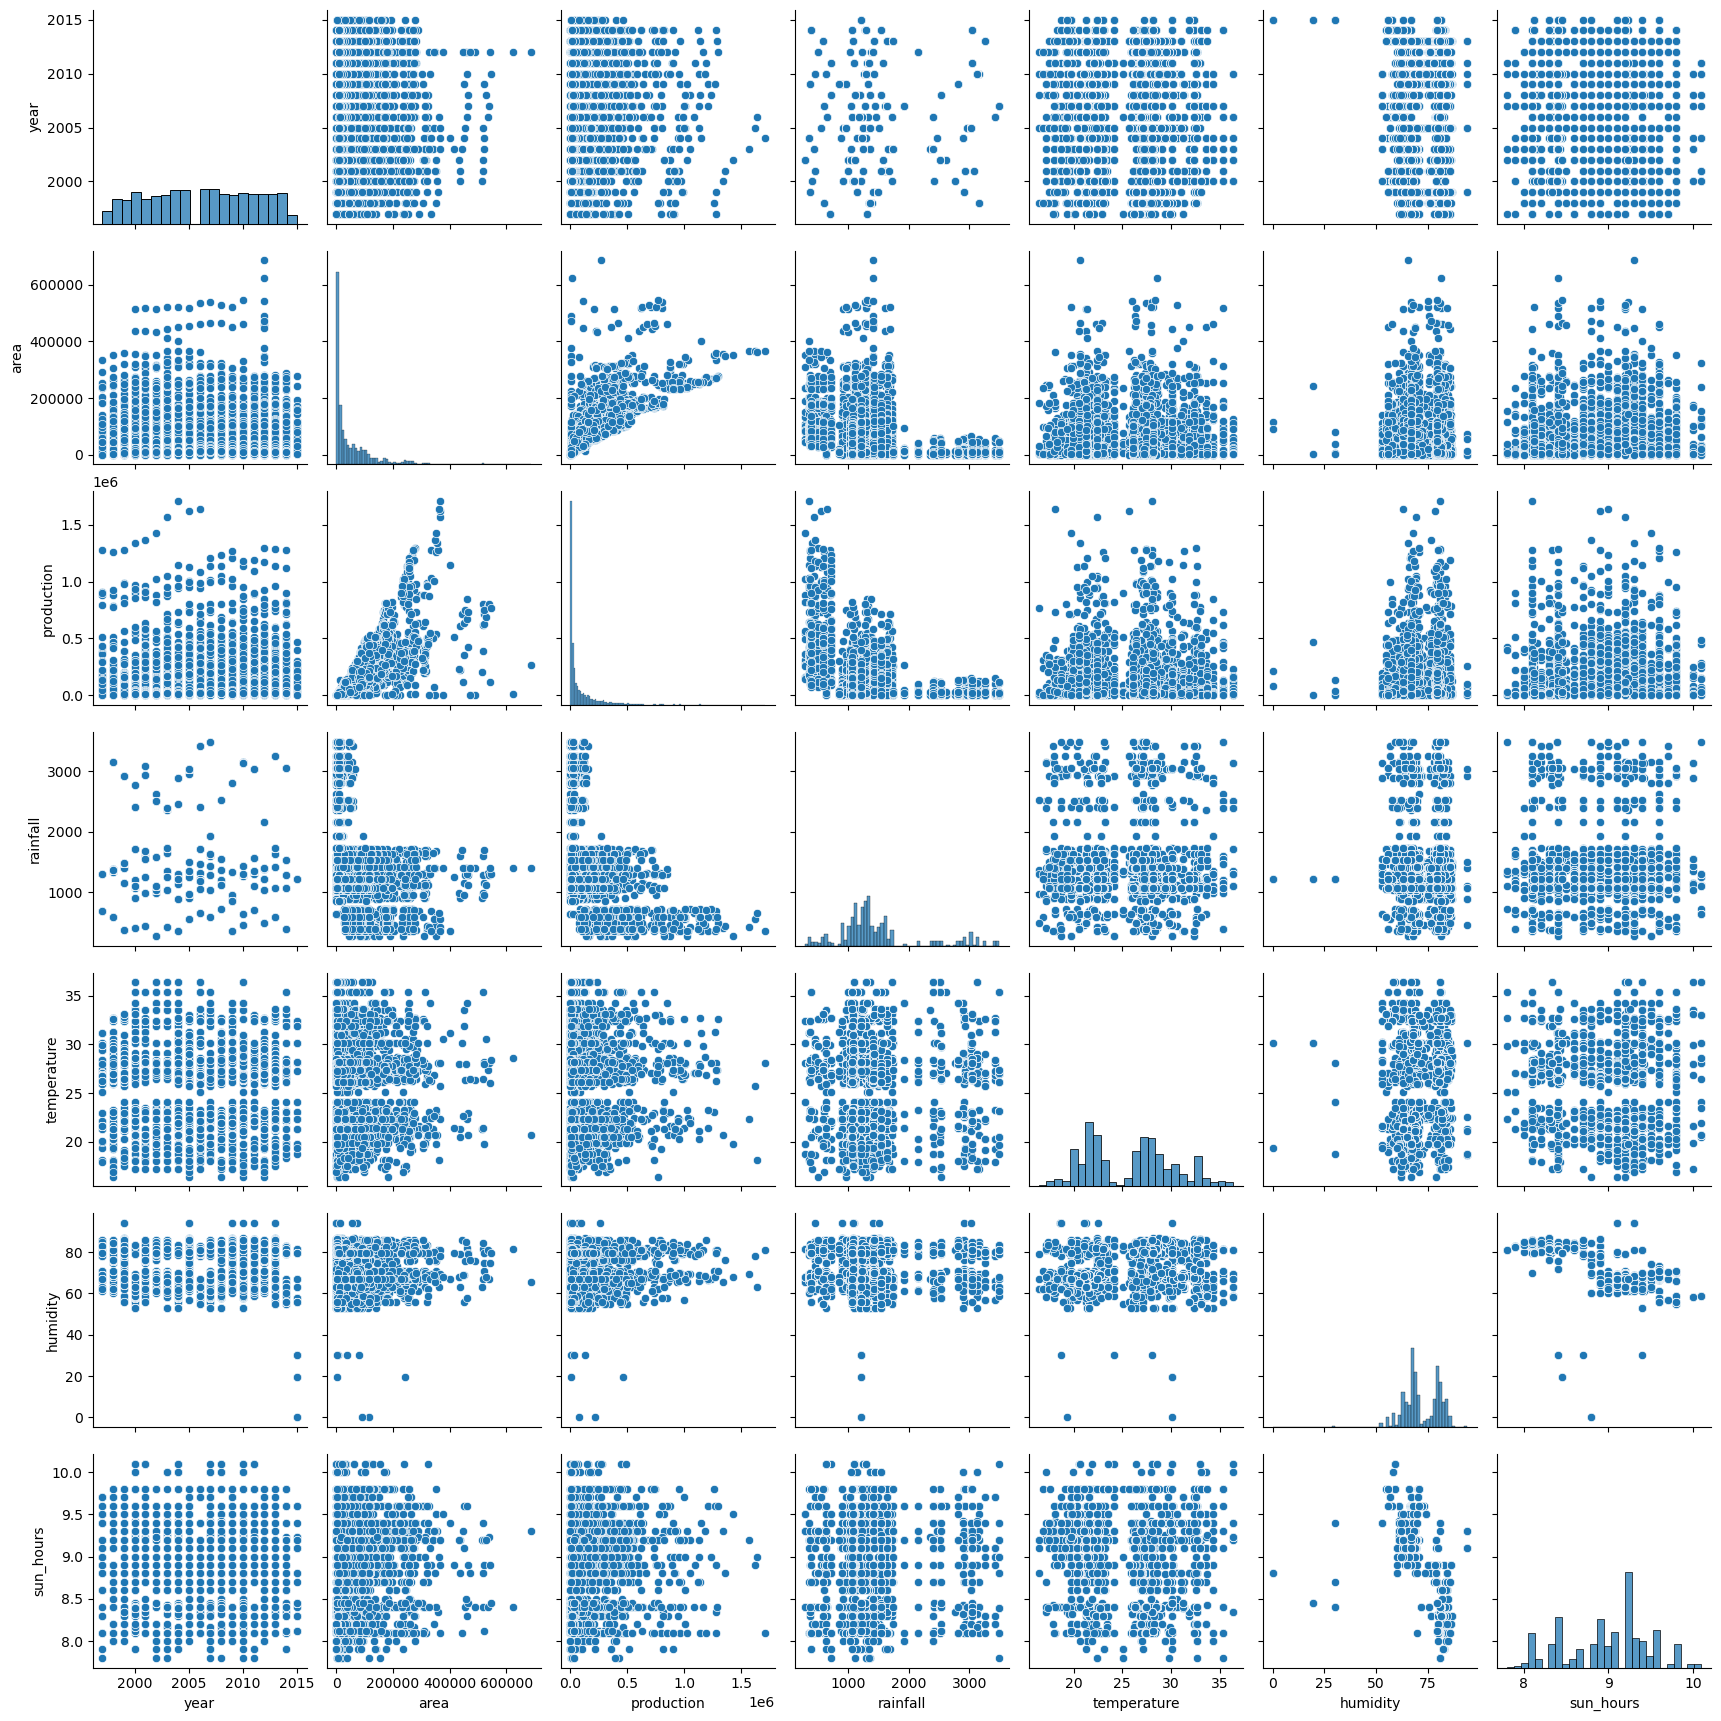

In [12]:
sns.pairplot(df)

#### 4.1. Distribution of State

In [13]:
def count(cols):
    # Set custom color palette
    custom_palette = sns.color_palette("viridis", n_colors=len(df[cols].unique()))

    # Set style
    sns.set(style="whitegrid", font_scale=1.2)

    plt.figure(figsize=(16, 6))

    # Count plot
    plt.subplot(1, 2, 1)
    count_plot = sns.countplot(x=cols, data=df, palette=custom_palette, order=df[cols].value_counts().index)
    plt.title(f'{cols} Distribution', pad=20, fontweight='bold', fontsize=20)
    plt.xticks(rotation=90)

    # for p in count_plot.patches:
    #     count_plot.annotate(format(p.get_height(), '.0f'),
    #                          (p.get_x() + p.get_width() / 2., p.get_height()),
    #                          ha='center', va='center',
    #                          xytext=(0, 9),
    #                          textcoords='offset points')

    # Bar plot
    plt.subplot(1, 2, 2)
    x = pd.DataFrame(df.groupby(cols)['production'].mean().sort_values(ascending = False))
    sns.barplot(x=x.index, y='production', data=x, palette=custom_palette)

    plt.xlabel(f'{cols}', fontsize=14)
    plt.ylabel('Production', fontsize=14)
    plt.title(f'Total Production in {cols}', pad=20, fontweight='bold', fontsize=20)
    plt.xticks(rotation=90)
    plt.show()

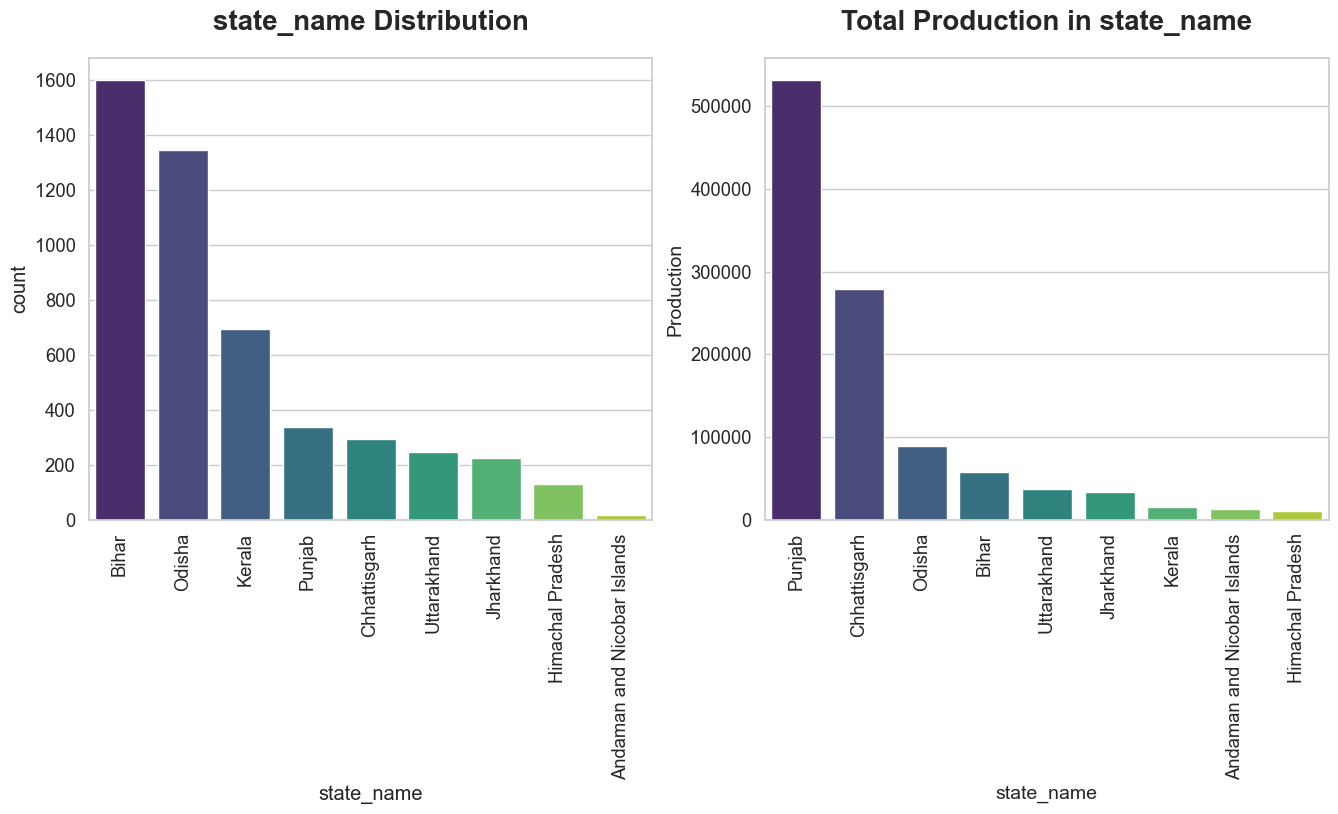

In [14]:
count('state_name')

#### 4.2. Distribution of Year

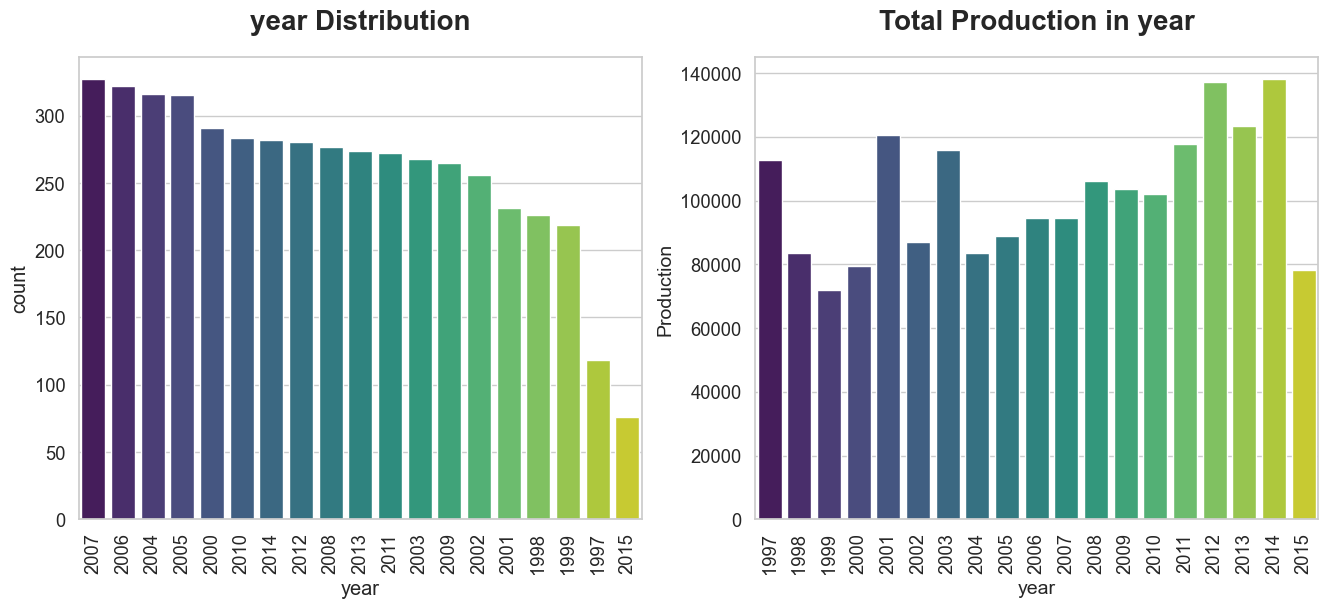

In [15]:
count('year')

#### 4.3. Distribution of Season

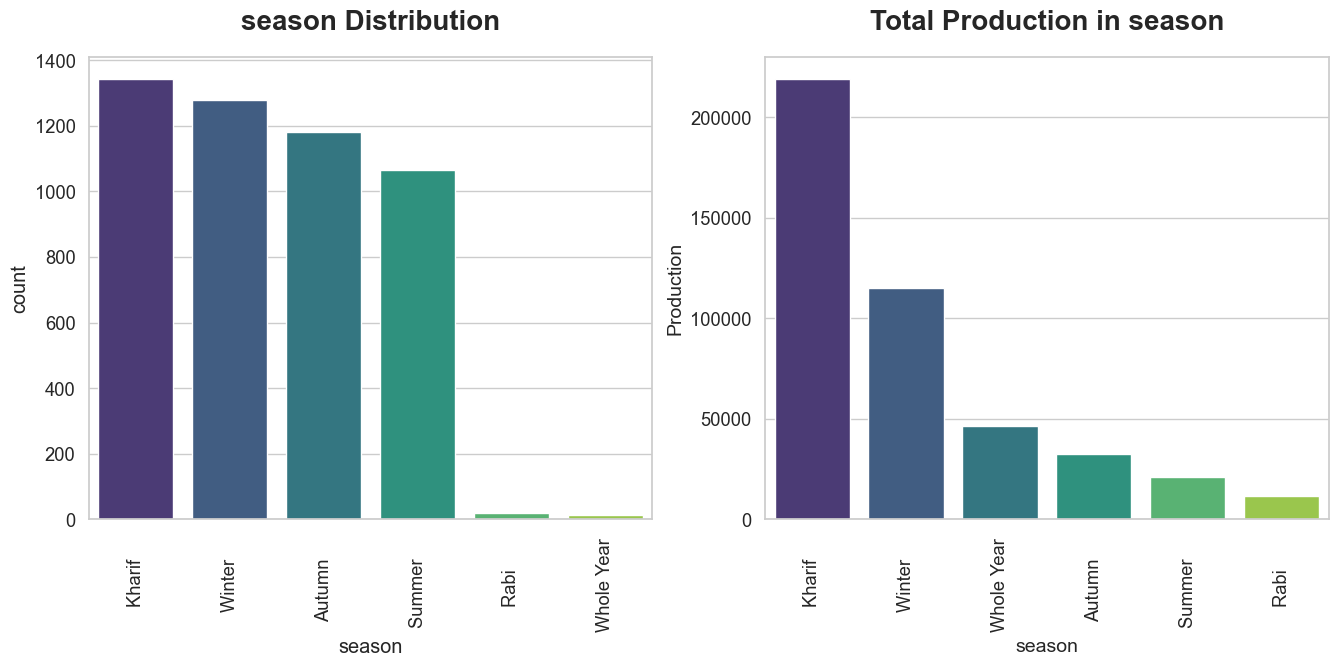

In [16]:
count('season')

#### 4.4. Trend of all features

In [17]:
def count_1(cols):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=cols, y='production', data=df, ci=None)
    plt.xlabel(f'{cols}', fontsize=14)
    plt.ylabel('Production', fontsize=14)
    plt.title(f'Production Over the {cols}', fontsize=18, fontweight='bold', pad=20)
    plt.show()

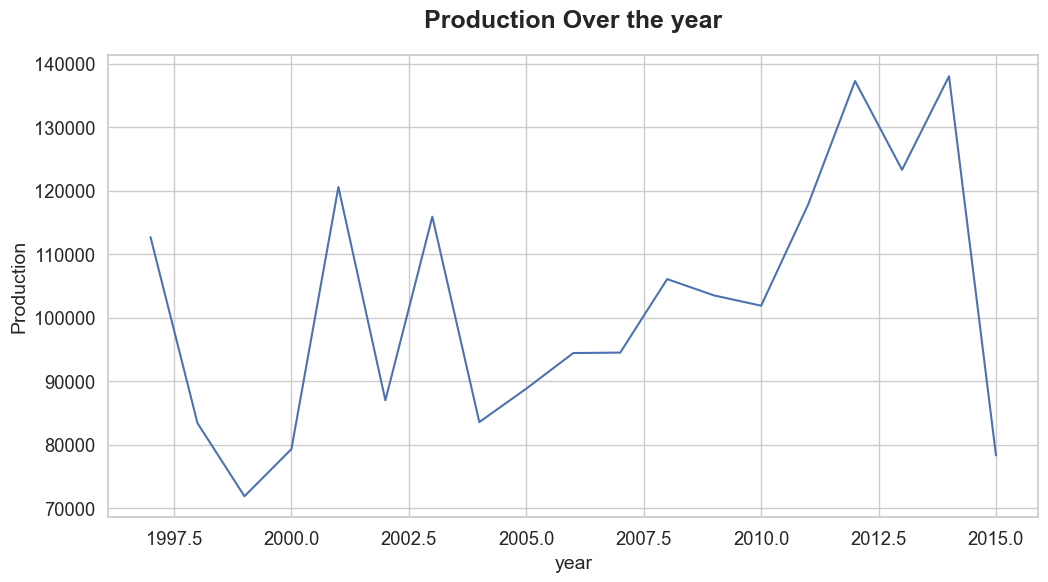

In [18]:
count_1('year')

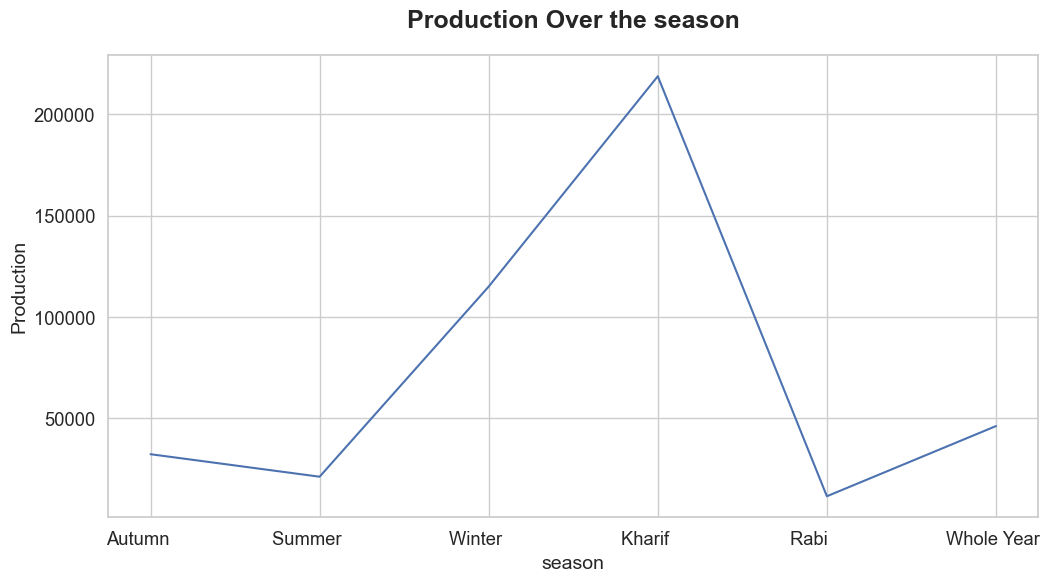

In [19]:
count_1('season')

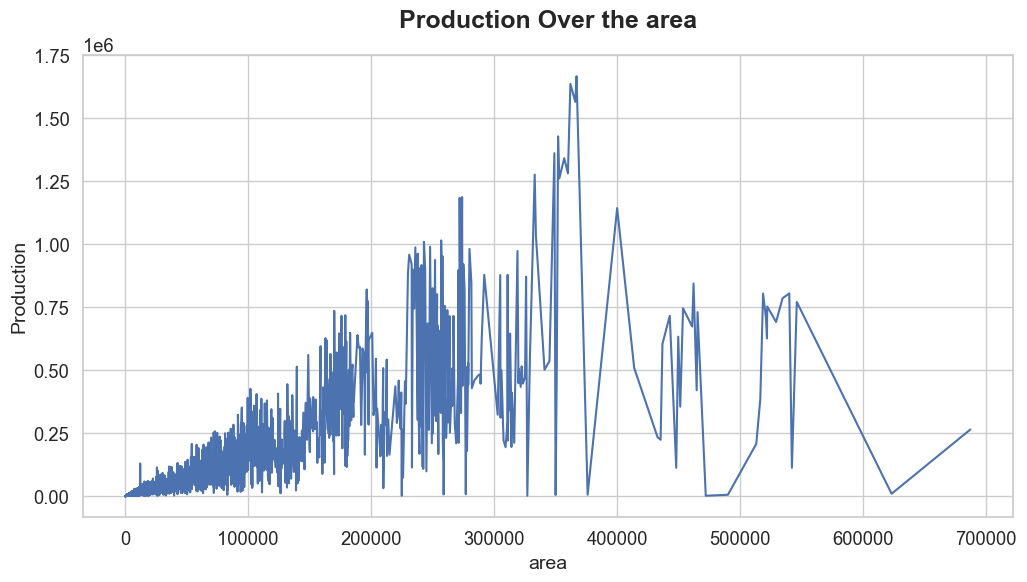

In [20]:
count_1('area')

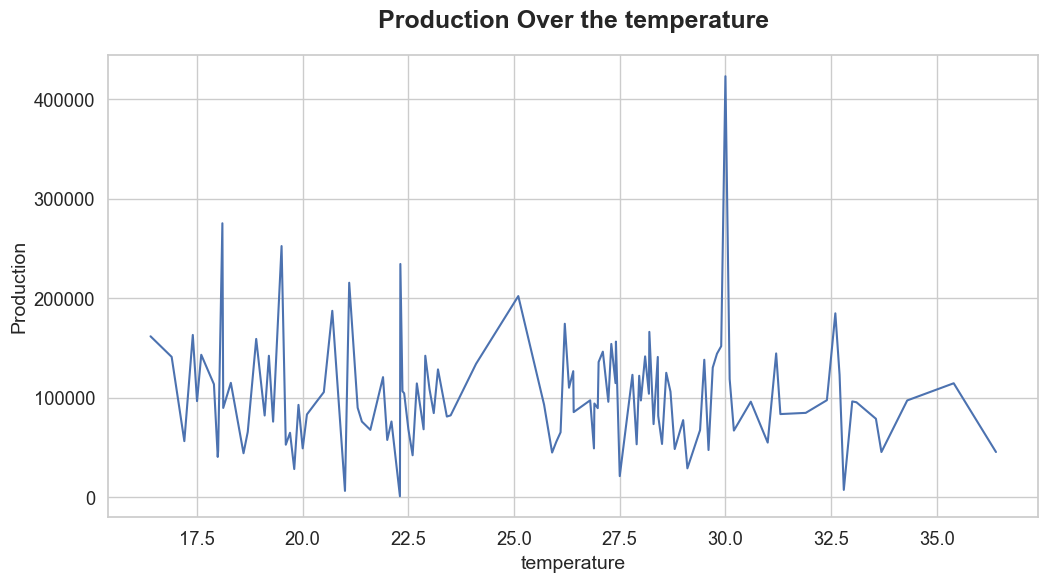

In [21]:
count_1('temperature')

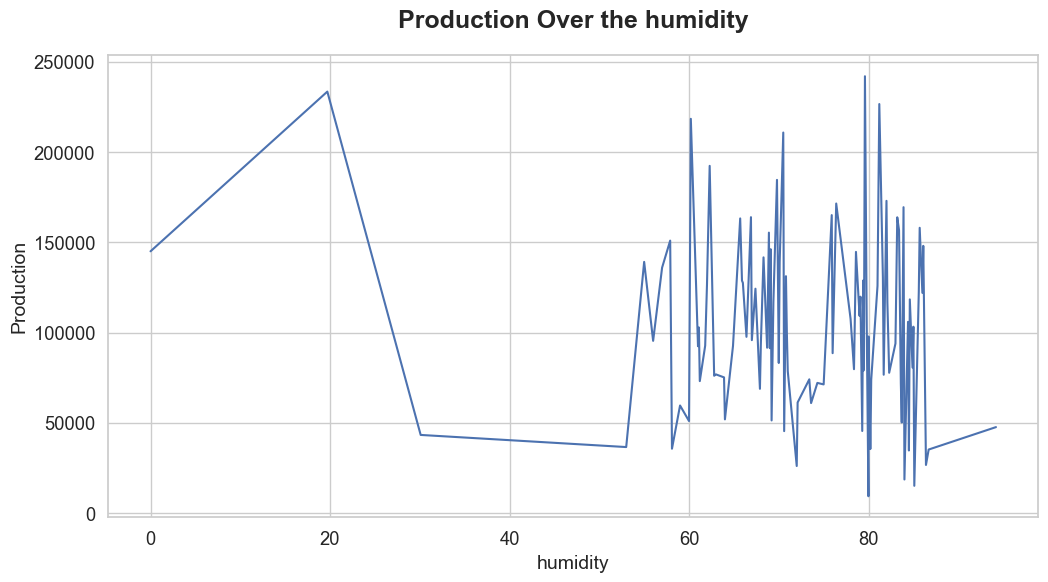

In [22]:
count_1('humidity')

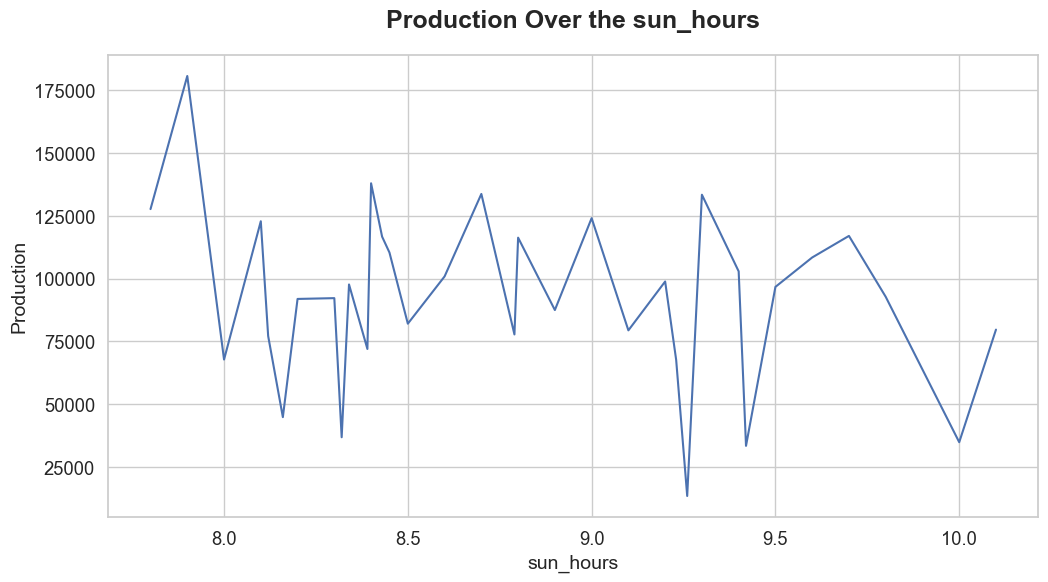

In [23]:
count_1('sun_hours')

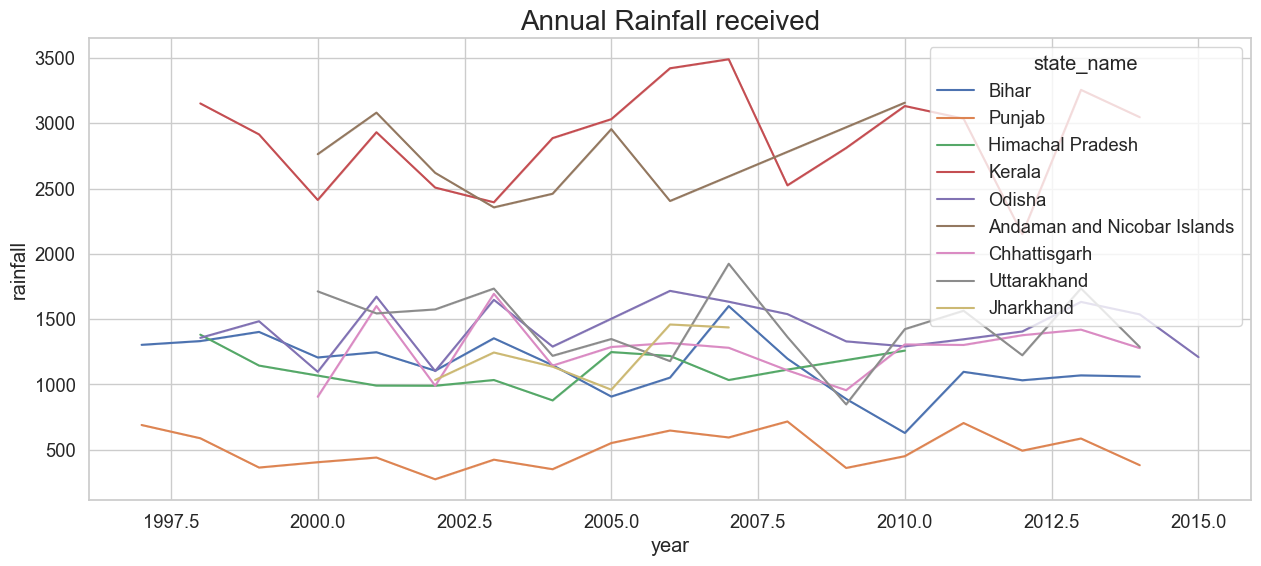

In [24]:
plt.figure(figsize=(15,6))
sns.lineplot(x = 'year', y= 'rainfall', hue = 'state_name', data = df)
plt.title('Annual Rainfall received',fontsize=20)
plt.show()

Text(0.5, 1.0, 'Highest Rainfall Year Data of States')

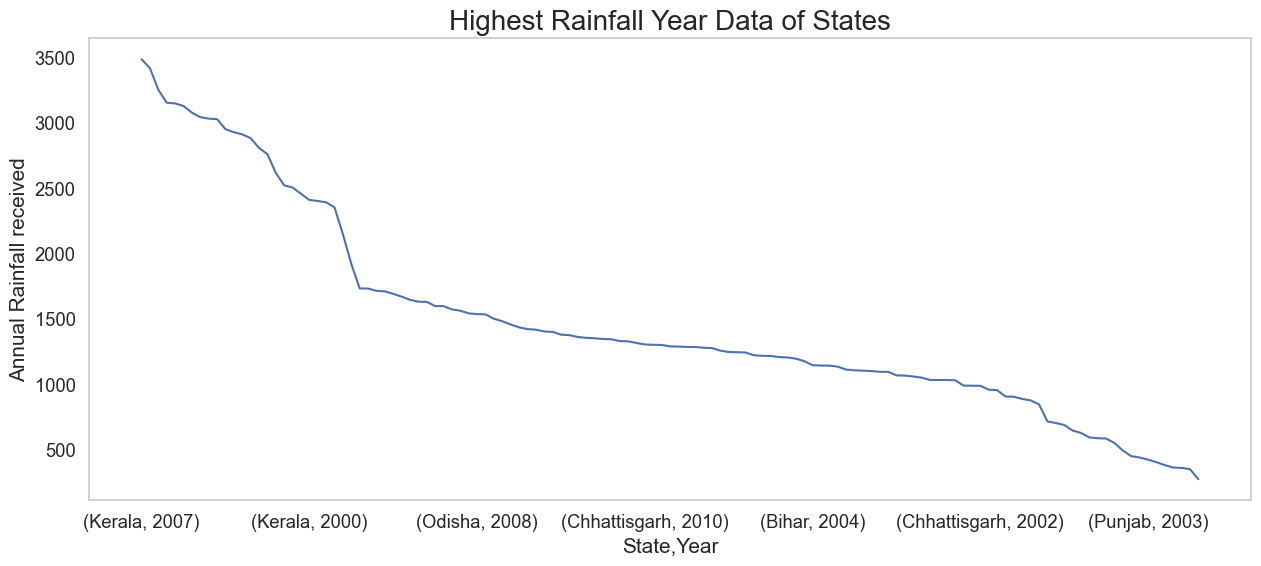

In [25]:
plt.figure(figsize=(15,6))
df.groupby(['state_name','year'])['rainfall'].mean().sort_values(ascending=False).plot()

plt.grid()
plt.xlabel("State,Year",fontsize=15)
plt.ylabel("Annual Rainfall received",fontsize=15)
plt.title('Highest Rainfall Year Data of States',fontsize=20)

Text(0.5, 1.0, 'Highest Rainfall Year of States')

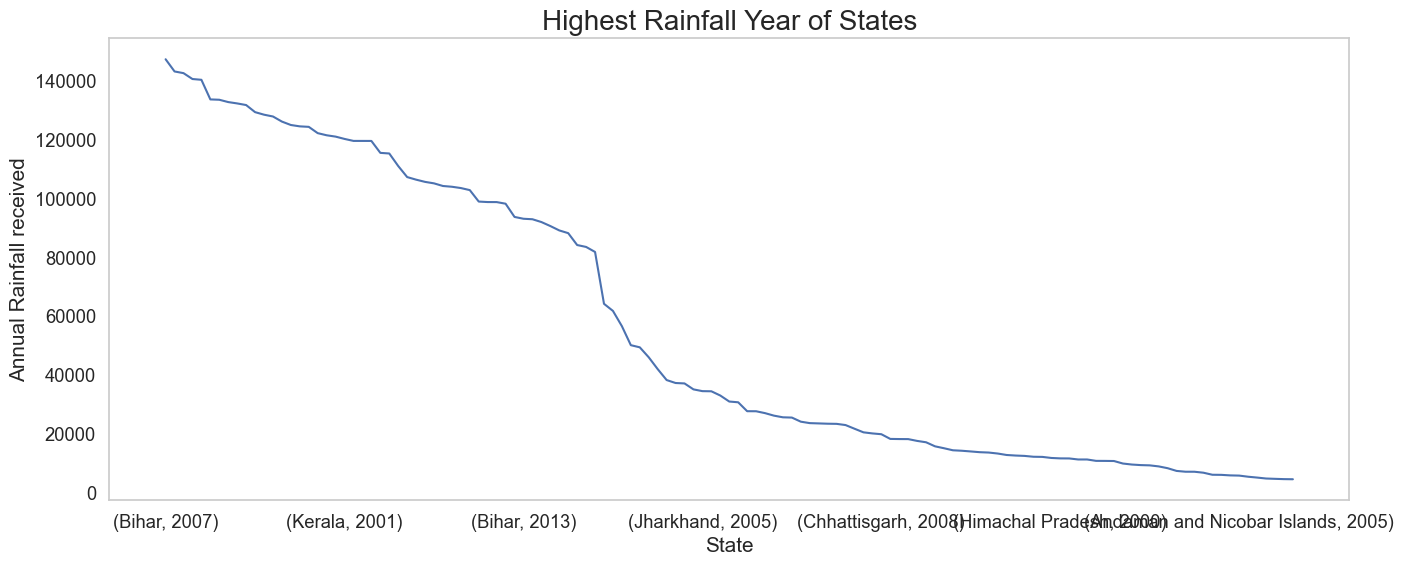

In [26]:
plt.figure(figsize=(16,6))
df.groupby(['state_name', 'year'])['rainfall'].sum().sort_values(ascending=False).plot()

plt.grid()
plt.xlabel("State",fontsize=15)
plt.ylabel("Annual Rainfall received",fontsize=15)
plt.title('Highest Rainfall Year of States',fontsize=20)

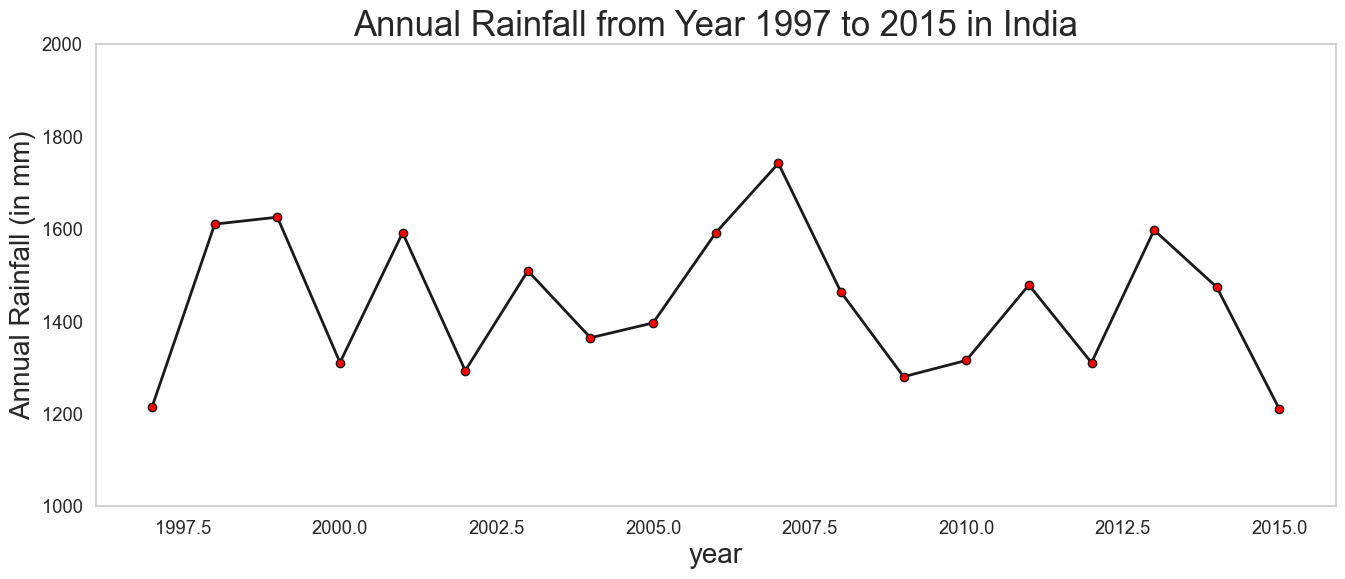

In [27]:
# Visualizing annual rainfall over the years(1997-2015) in India
df.groupby("year").mean()['rainfall'].plot(ylim=(1000,2000),color='k',marker='o',markerfacecolor='red',linestyle='-',linewidth=2,figsize=(16,6))
plt.xlabel('year',fontsize=20)
plt.ylabel('Annual Rainfall (in mm)',fontsize=20)
plt.title('Annual Rainfall from Year 1997 to 2015 in India',fontsize=25)

plt.grid()

### 5. Data Pre-Processing

#### 5.1. Handling with missing values

In [28]:
df.isnull().sum()

state_name         0
district_name      0
year               0
season             0
area               0
production        10
rainfall           0
temperature      163
humidity          66
sun_hours         47
dtype: int64

In [29]:
# Find and print columns with missing values
missing_columns = df.columns[df.isnull().any()].tolist()
missing_columns

['production', 'temperature', 'humidity', 'sun_hours']

In [30]:
# count the number of rows with at least one missing value
missing_rows = df.isna().any(axis=1).sum()

# count the number of rows without missing values
non_missing_rows = len(df) - missing_rows

In [31]:
print(f'Missing rows: {missing_rows}')
print(f'Non-Missing values: {non_missing_rows}')

Missing rows: 267
Non-Missing values: 4631


In [32]:
percentage_missing_values = missing_rows / len(df) * 100
print(f"Percentage of missing values with respect to the whole data set: {percentage_missing_values} %")

Percentage of missing values with respect to the whole data set: 5.451204573295223 %


**Only 5.451% of our entire datasset contains missing values....**

In [33]:
# plot the results as a pie chart
labels = ['Rows with missing values', 'Rows without missing values']
sizes = [missing_rows, non_missing_rows]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0) 

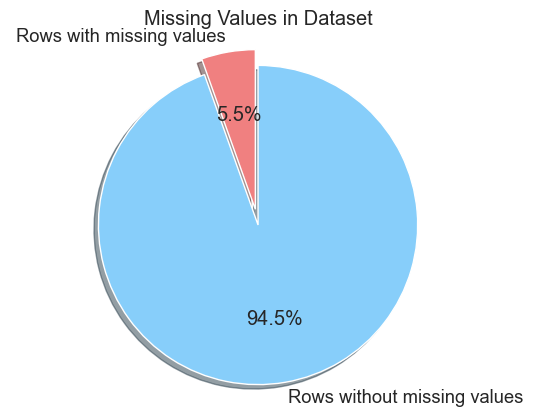

In [34]:
def missing_value():
        plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
        plt.axis('equal')
        plt.title('Missing Values in Dataset')
        plt.show()
missing_value()

In this case we can't just simply drop the null value like usual, It might affect the data, Choosing Imputing missling values would be a good choice in this scenario.

In [35]:
# Columns to impute
columns_to_impute = ['production', 'temperature', 'humidity', 'sun_hours']

# Applying median imputation
for column in columns_to_impute:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

# Rechecking for missing values
missing_values_after_imputation = df.isnull().sum()

In [36]:
missing_values_after_imputation

state_name       0
district_name    0
year             0
season           0
area             0
production       0
rainfall         0
temperature      0
humidity         0
sun_hours        0
dtype: int64

#### 5.2. Handling with  Outliers

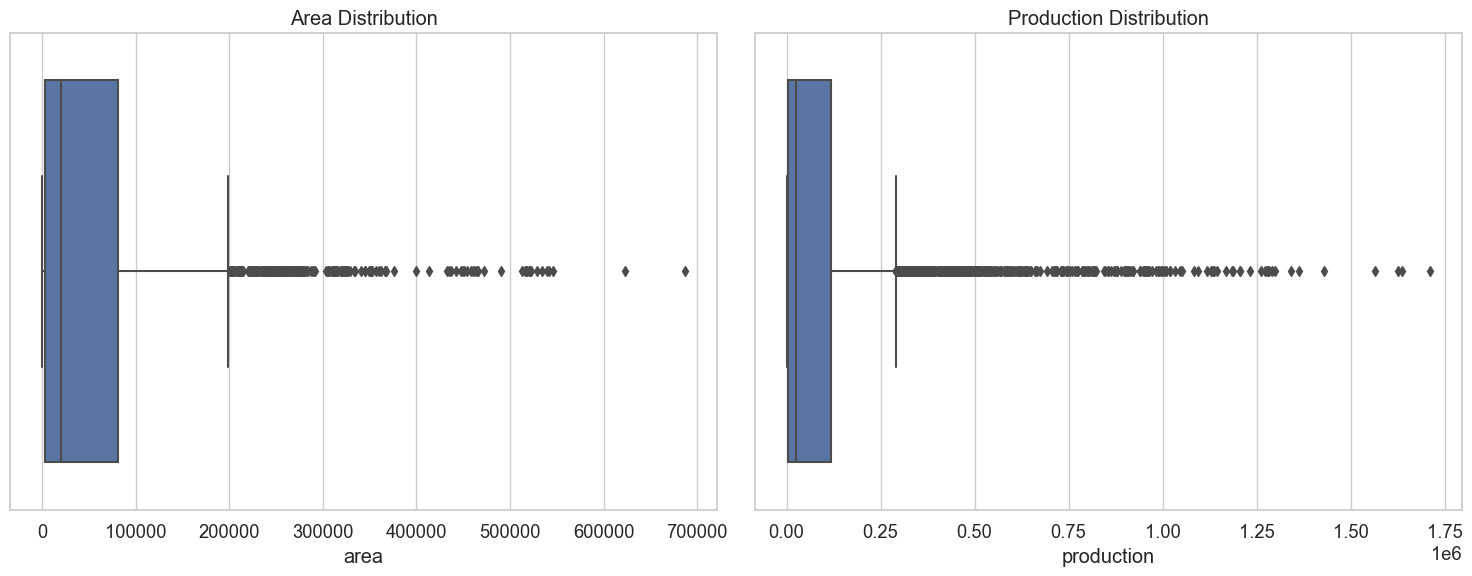

In [37]:
def Visualizing_outlier():
    # Visualizing distributions of numerical variables
    plt.figure(figsize=(15, 6))

    # Area distribution
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df['area'])
    plt.title('Area Distribution')

    # Production distribution
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df['production'])
    plt.title('Production Distribution')

    plt.tight_layout()
    plt.show()
Visualizing_outlier()

In [38]:
def detect_outliers_iqr(data, column_name):
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    return outliers

# Detecting outliers in the 'Area' and 'Production' columns
outliers_area = detect_outliers_iqr(df, 'area')
outliers_production = detect_outliers_iqr(df, 'production')

# Count of outliers in each column
outliers_count = {
    'Area_Outliers_Count': outliers_area.shape[0],
    'Production_Outliers_Count': outliers_production.shape[0]
}

In [39]:
outliers_count, outliers_area.head(), outliers_production.head()

({'Area_Outliers_Count': 304, 'Production_Outliers_Count': 507},
     state_name district_name  year       season      area  production  \
 76       Bihar        ROHTAS  1997  Winter       203149.0    360295.0   
 101     Punjab      AMRITSAR  1997  Kharif       292000.0    879000.0   
 105     Punjab     FIROZEPUR  1997  Kharif       252000.0    910000.0   
 110     Punjab      LUDHIANA  1997  Kharif       234000.0    899000.0   
 115     Punjab       PATIALA  1997  Kharif       240000.0    792000.0   
 
      rainfall  temperature  humidity  sun_hours  
 76     1303.7         22.9      68.0        9.2  
 101     690.1         21.6      69.0        9.0  
 105     690.1         21.6      69.0        9.0  
 110     690.1         29.9      67.0        9.4  
 115     690.1         26.2      79.8        8.9  ,
     state_name    district_name  year       season      area  production  \
 4        Bihar       AURANGABAD  1997  Winter       185191.0    382670.0   
 76       Bihar           RO

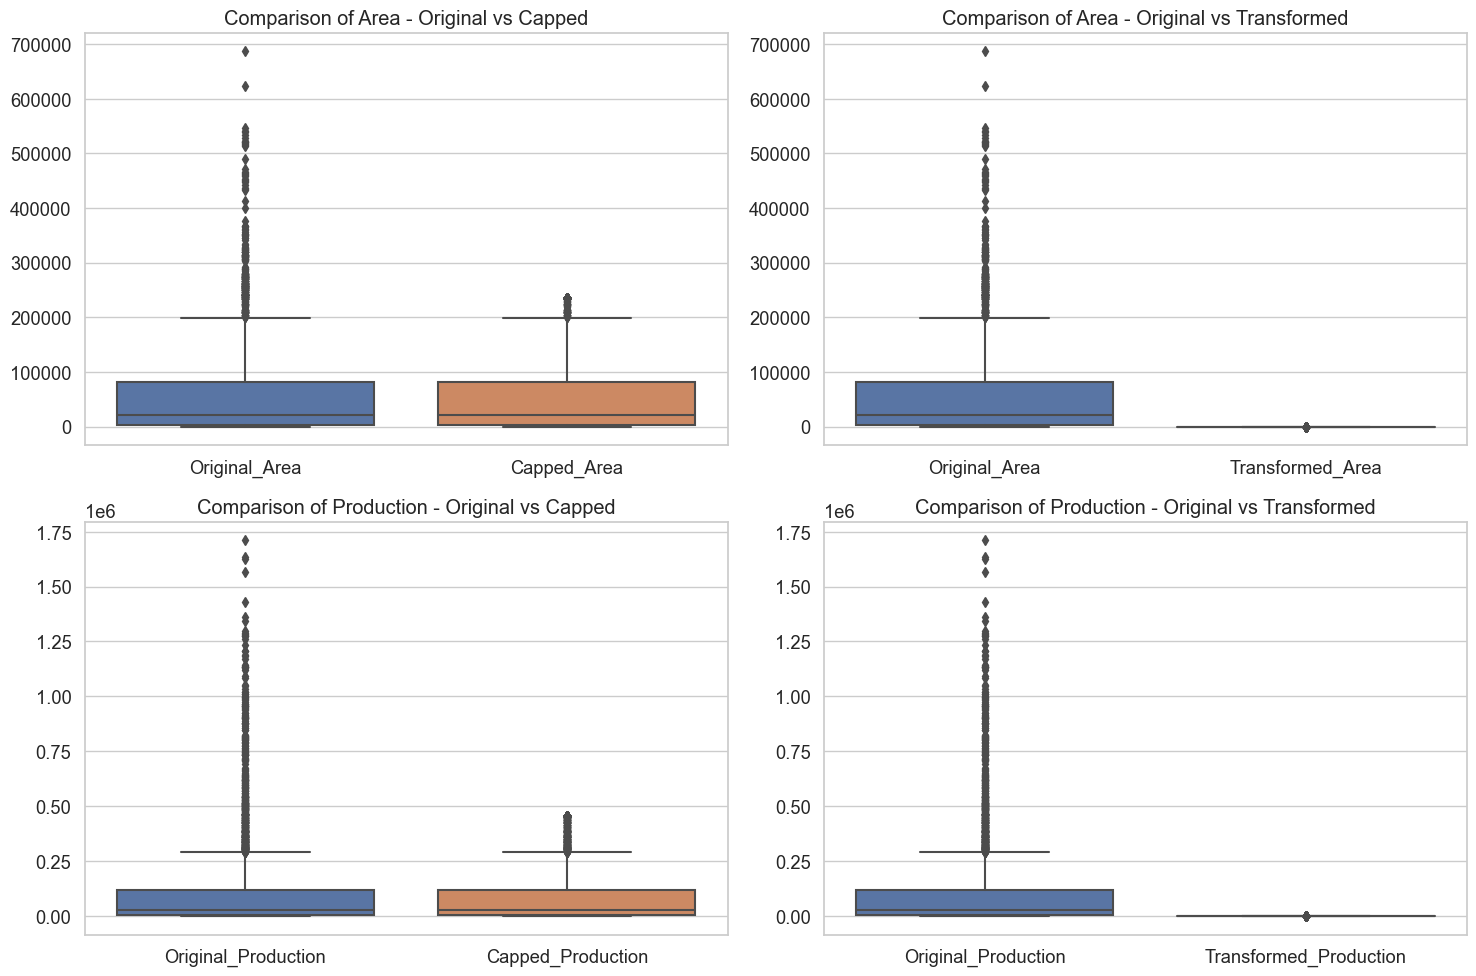

,Original_Area,Capped_Area,Transformed_Area,Original_Production,Capped_Production,Transformed_Production
0,17876.0,17876.0,9.791270,21397.0,21397.0,9.971053
1,8479.0,8479.0,9.045466,13993.0,13993.0,9.546384
2,93975.0,93975.0,11.450795,121063.0,121063.0,11.704075
3,10.0,83.0,2.397895,19.0,151.0,2.995732
4,185191.0,185191.0,12.129148,382670.0,382670.0,12.854931


In [40]:
# Capping (Winsorizing) Outliers
# Setting the limits to 5th and 95th percentile for both columns
capped_area = winsorize(df['area'], limits=[0.05, 0.05])
capped_production = winsorize(df['production'], limits=[0.05, 0.05])

# Transforming Outliers using Log Transformation
# Adding a small constant to avoid log(0) which is undefined
transformed_area = np.log(df['area'] + 1)
transformed_production = np.log(df['production'] + 1)

# Creating a new DataFrame for comparison
comparison_df = pd.DataFrame({
    'Original_Area': df['area'],
    'Capped_Area': capped_area,
    'Transformed_Area': transformed_area,
    'Original_Production': df['production'],
    'Capped_Production': capped_production,
    'Transformed_Production': transformed_production
})

# Comparing the effect of both methods on Area and Production
plt.figure(figsize=(15, 10))

# Area Comparison
plt.subplot(2, 2, 1)
sns.boxplot(data=comparison_df[['Original_Area', 'Capped_Area']])
plt.title('Comparison of Area - Original vs Capped')

plt.subplot(2, 2, 2)    
sns.boxplot(data=comparison_df[['Original_Area', 'Transformed_Area']])
plt.title('Comparison of Area - Original vs Transformed')

# Production ComparisonF
plt.subplot(2, 2, 3)
sns.boxplot(data=comparison_df[['Original_Production', 'Capped_Production']])
plt.title('Comparison of Production - Original vs Capped')

plt.subplot(2, 2, 4)
sns.boxplot(data=comparison_df[['Original_Production', 'Transformed_Production']])
plt.title('Comparison of Production - Original vs Transformed')

plt.tight_layout()
plt.show()

# Returning the comparison DataFrame for further analysis if needed
comparison_df.head()

<b>FYI</b>:How Capping works,  Capping outliers at a certain percentile. For example, values above the 95th percentile and below the 5th percentile can be capped.

After comparison of these two techniques, We can see that <b>Capping</b> technique shows better performance on handling outlier without losing its value of the dataset and reduced outliers to a certain point.

In [41]:
# Replace the original columns with the capped versions
df['area'] = capped_area
df['production'] = capped_production

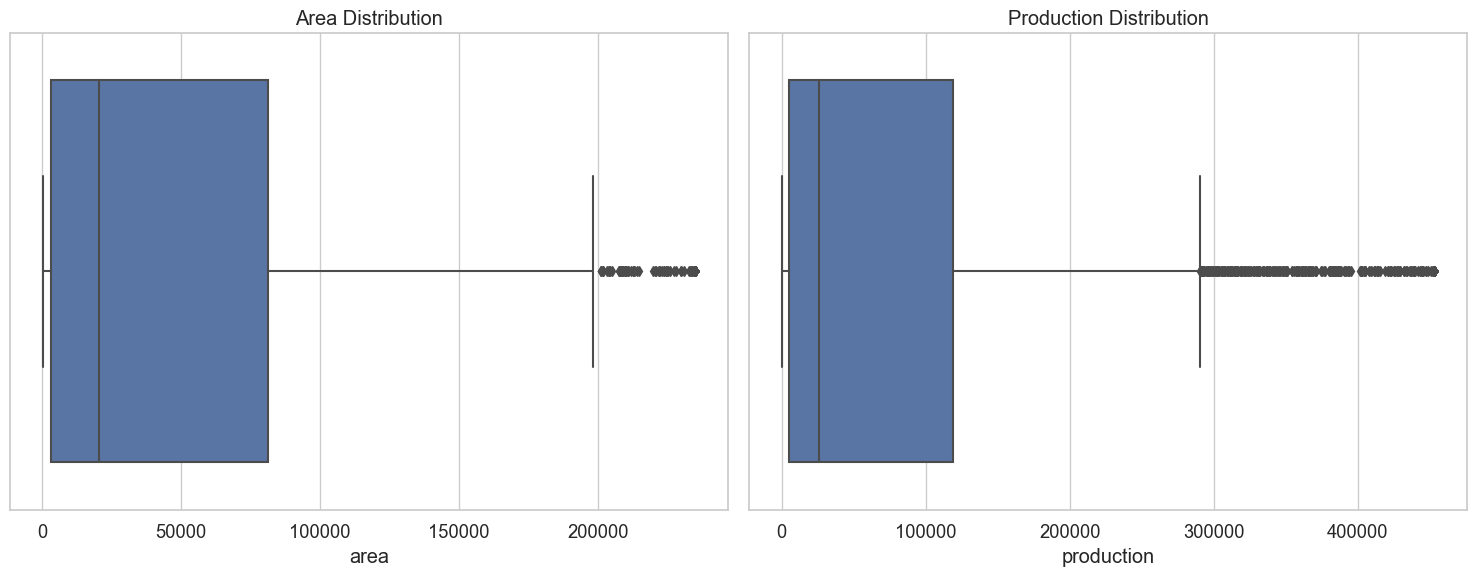

In [42]:
def numberical_feature():
    # Visualizing distributions of numerical variables
    plt.figure(figsize=(15, 6))

    # Area distribution
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df['area'])
    plt.title('Area Distribution')

    # Production distribution
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df['production'])
    plt.title('Production Distribution')

    plt.tight_layout()
    plt.show()
numberical_feature()

#### 5.3. Handling with Imbalanced Data using Resampling Technique

In [43]:
# Checking for imbalance in categorical variables
categorical_columns = ['state_name', 'district_name', 'season']

# Getting the value counts for each categorical column
imbalance_check = {col: df[col].value_counts() for col in categorical_columns}

imbalance_check['state_name'].head(), imbalance_check['district_name'].head(), imbalance_check['season'].head()

(Bihar           1602
 Odisha          1346
 Kerala           695
 Punjab           338
 Chhattisgarh     294
 Name: state_name, dtype: int64,
 SUPAUL      53
 ARARIA      52
 PURNIA      52
 SAHARSA     52
 VAISHALI    52
 Name: district_name, dtype: int64,
 Kharif         1342
 Winter         1278
 Autumn         1182
 Summer         1065
 Rabi             18
 Name: season, dtype: int64)

For <b>categorical variables</b> like season, where the imbalance is not extreme (except for 'Rabi'), a combination of oversampling the minority class ('Rabi') and undersampling the majority classes ('Kharif', 'Winter', 'Autumn') could be effective. This would balance the dataset without losing much valuable information.
For <b>state_name and district_name</b>, since the number of unique categories is large and the distribution is more varied, oversampling minor categories might introduce too much synthetic variance. Therefore, a cautious approach to resampling, focusing on moderately represented categories, would be beneficial.

In [44]:
# Trimming trailing spaces from the 'season' column
df['season'] = df['season'].str.strip()

# Redefining the datasets by season after trimming spaces
df_kharif = df[df['season'] == 'Kharif']
df_winter = df[df['season'] == 'Winter']
df_autumn = df[df['season'] == 'Autumn']
df_summer = df[df['season'] == 'Summer']
df_rabi = df[df['season'] == 'Rabi']
df_whole_year = df[df['season'] == 'Whole Year']  # Including 'Whole Year' season

# Finding the number of samples in the 'Summer' season (next smallest class)
summer_size = df['season'].value_counts()['Summer']

# Upsampling 'Rabi' and downsampling other seasons to the size of 'Summer'
df_kharif_resampled = resample(df_kharif, replace=False, n_samples=summer_size, random_state=123)
df_winter_resampled = resample(df_winter, replace=False, n_samples=summer_size, random_state=123)
df_autumn_resampled = resample(df_autumn, replace=False, n_samples=summer_size, random_state=123)
df_summer_resampled = df_summer.copy()  # No need to resample
df_rabi_resampled = resample(df_rabi, replace=True, n_samples=summer_size, random_state=123)
df_whole_year_resampled = resample(df_whole_year, replace=True, n_samples=summer_size, random_state=123)

# Combining the resampled dataframes
resampled_df = pd.concat([df_kharif_resampled, df_winter_resampled, df_autumn_resampled, 
                          df_summer_resampled, df_rabi_resampled, df_whole_year_resampled])

# Checking the balance in the 'season' variable after resampling
season_balance_check = resampled_df['season'].value_counts()
season_balance_check

Kharif        1065
Winter        1065
Autumn        1065
Summer        1065
Rabi          1065
Whole Year    1065
Name: season, dtype: int64

<b>Upsample 'Rabi' Season</b>: Since 'Rabi' has very few samples, we'll upsample it to a reasonable number, closer to the count of the 'Summer' season, which is the next smallest class.

<b>Downsample Other Seasons</b>: We'll downsample the 'Kharif', 'Winter', and 'Autumn' seasons to match the count of the 'Summer' season.

In [45]:
X = resampled_df.drop(['state_name', 'district_name', 'production'], axis=1)
y = resampled_df['production']

# Preprocessing - OneHotEncoding for categorical variable 'season'
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['season'])
    ], remainder='passthrough')

# Creating a pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model_pipeline.fit(X_train, y_train)

# Predicting on the test set
y_pred = model_pipeline.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

(1112025896.0498686, 0.916492206343235)

In [46]:
resampled_df.columns

Index(['state_name', 'district_name', 'year', 'season', 'area', 'production',
       'rainfall', 'temperature', 'humidity', 'sun_hours'],
      dtype='object')

In [47]:
resampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6390 entries, 2224 to 4800
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   state_name     6390 non-null   object 
 1   district_name  6390 non-null   object 
 2   year           6390 non-null   int64  
 3   season         6390 non-null   object 
 4   area           6390 non-null   float64
 5   production     6390 non-null   float64
 6   rainfall       6390 non-null   float64
 7   temperature    6390 non-null   float64
 8   humidity       6390 non-null   float64
 9   sun_hours      6390 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 549.1+ KB


**Prepare data fro encode**

**We decide to drop Year and District Name**

In [48]:
resampled_df.drop(columns=['district_name', 'year', 'sun_hours'], inplace=True)

In [49]:
resampled_df

,state_name,season,area,production,rainfall,temperature,humidity
2224,Punjab,Kharif,235000.0,452873.0,552.0,25.71,78.38
1206,Himachal Pradesh,Kharif,3377.0,5377.0,990.4,34.30,82.00
187,Himachal Pradesh,Kharif,2891.0,3878.0,1381.6,28.10,82.30
1190,Chhattisgarh,Kharif,108984.0,82439.0,990.2,27.96,69.00
4790,Punjab,Kharif,29000.0,94000.0,382.7,27.40,79.80
...,...,...,...,...,...,...,...
4798,Uttarakhand,Whole Year,11265.0,14414.0,1287.4,21.30,63.00
4810,Uttarakhand,Whole Year,14566.0,17359.0,1287.4,31.90,56.00
4808,Uttarakhand,Whole Year,11793.0,33161.0,1287.4,31.90,56.00
4794,Uttarakhand,Whole Year,16897.0,19776.0,1287.4,21.30,69.80


**5.4. Encode Data**

In [50]:
df = resampled_df.copy()

In [51]:
df

,state_name,season,area,production,rainfall,temperature,humidity
2224,Punjab,Kharif,235000.0,452873.0,552.0,25.71,78.38
1206,Himachal Pradesh,Kharif,3377.0,5377.0,990.4,34.30,82.00
187,Himachal Pradesh,Kharif,2891.0,3878.0,1381.6,28.10,82.30
1190,Chhattisgarh,Kharif,108984.0,82439.0,990.2,27.96,69.00
4790,Punjab,Kharif,29000.0,94000.0,382.7,27.40,79.80
...,...,...,...,...,...,...,...
4798,Uttarakhand,Whole Year,11265.0,14414.0,1287.4,21.30,63.00
4810,Uttarakhand,Whole Year,14566.0,17359.0,1287.4,31.90,56.00
4808,Uttarakhand,Whole Year,11793.0,33161.0,1287.4,31.90,56.00
4794,Uttarakhand,Whole Year,16897.0,19776.0,1287.4,21.30,69.80


**We will use one hot encode since or categorical variables don't have a natural ordinal relationship**

In [52]:
le=LabelEncoder()

In [53]:
label_mapping = {'Bihar':0, 'Punjab':1, 'Himachal Pradesh':2, 'Kerala':3, 'Odisha':4, 
                 'Andaman and Nicobar Islands':5, 'Chhattisgarh':6, 'Uttarakhand':7, 'Jharkhand':8}
resampled_df['state_name'] = resampled_df['state_name'].map(label_mapping)

In [54]:
label_mapping = {'Autumn':0, 'Whole Year':1, 'Kharif':2, 'Winter':3, 'Summer':4, 'Rabi':5}
resampled_df['season'] = resampled_df['season'].map(label_mapping)

In [55]:
resampled_df

,state_name,season,area,production,rainfall,temperature,humidity
2224,1,2,235000.0,452873.0,552.0,25.71,78.38
1206,2,2,3377.0,5377.0,990.4,34.30,82.00
187,2,2,2891.0,3878.0,1381.6,28.10,82.30
1190,6,2,108984.0,82439.0,990.2,27.96,69.00
4790,1,2,29000.0,94000.0,382.7,27.40,79.80
...,...,...,...,...,...,...,...
4798,7,1,11265.0,14414.0,1287.4,21.30,63.00
4810,7,1,14566.0,17359.0,1287.4,31.90,56.00
4808,7,1,11793.0,33161.0,1287.4,31.90,56.00
4794,7,1,16897.0,19776.0,1287.4,21.30,69.80


In [56]:
# resampled_df['state_name'] = resampled_df['state_name'].astype('category') 
# resampled_df['season'] = resampled_df['season'].astype('category')
  
# enc = OneHotEncoder() 
  
# enc_data = pd.DataFrame(enc.fit_transform( 
#     resampled_df[['state_name', 'season']]).toarray()) 

# resampled_df = resampled_df.join(enc_data) 

In [57]:
# resampled_df = resampled_df.drop(['state_name','season'], axis=1)

In [58]:
# resampled_df.columns = resampled_df.columns.astype(str)

In [59]:
# resampled_df

**5.5. Split and Scale Data**

In [60]:
target = resampled_df["production"]
features = resampled_df.drop("production", axis = 1)
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.2, random_state = 42)

sc = StandardScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train))
X_test_sc = pd.DataFrame(sc.transform(X_test))

**Using Grid Search Cross Validation for choosing the best parameters of models based on obtained scores.**

In [61]:
def get_best_model(grid):
    best_model = grid.best_estimator_
    print("Best Model:", best_model)
    print("Best Params:", grid.best_params_)
    return best_model

In [62]:
def get_best_score(grid):
    best_score = np.sqrt(-grid.best_score_)
    print("Best Score:", best_score)
    return best_score

### 6. Model Building

**Scikit-learn offers a wide variety of regression algorithms. We'll build simple to complex regression models using different algorithms and will compare the results obtained over different models with our testing dataset which contains 20% of original dataset. For tuning the model and selecting optimum parameters. We'll use GridSearch cross validation.**

**We test the following Regressors from scikit-learn:**

* LinearRegression
* DecisionTreeRegressor
* RandomForestRegressor
* KNN Regressor
* XGBoost Regressor

#### 6.1. Linear Regression


In [63]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv = folds, verbose = 1 , scoring = score_calc)
grid_linear.fit(X_train, Y_train)

LR = get_best_model(grid_linear)
sc_LR = get_best_score(grid_linear)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Model: LinearRegression()
Best Params: {'copy_X': True, 'fit_intercept': True}
Best Score: 54453.42148657194


In [64]:
#Fit Model
#LR = LinearRegression()
LR.fit(X_train, Y_train)
pred_linreg_all = LR.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [65]:
# Calculate R-squared for the training set
train_r2 = r2_score(Y_train, LR.predict(X_train))
print("R-squared on Training Set:", train_r2)

# Calculate R-squared for the test se
test_r2 = r2_score(Y_test, pred_linreg_all)
print("R-squared on Test Set:", test_r2)

R-squared on Training Set: 0.7612540522177519
R-squared on Test Set: 0.7345603866960104


In [66]:
#Display the predict value of production
pred_linreg_all

array([66334.98711821,  9762.36705611, 82250.02177902, ...,
       26684.4192097 , 28776.58577847, 35710.05445194])

**6.2.Decision Tree Regressor**

**Let's begin by choose the best hyperparameters for our model**

In [67]:
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': [5, 7, 10, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt', 'log2', None]  
}

grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = folds, refit = True, verbose = 0, scoring = score_calc)
grid_dtree.fit(X_train, Y_train)

best_dtree = get_best_model(grid_dtree)
sc_dtree = get_best_score(grid_dtree)

Best Model: DecisionTreeRegressor(max_depth=7, min_samples_split=10)
Best Params: {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Score: 37595.55012350656


e:\Programm\Anaconda\envs\Crop2\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "e:\Programm\Anaconda\envs\Crop2\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\Programm\Anaconda\envs\Crop2\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "e:\Programm\Anaconda\envs\Crop2\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "e:\Programm\

**After we found the best hyperparameters for our model, we will use this value to build our model**

In [68]:
best_dtree.fit(X_train, Y_train)

dtree_predictions = best_dtree.predict(X_test)

# MSE and R-squared for the test set
test_r2 = r2_score(Y_test, dtree_predictions)
print("R-squared on Test Set:", test_r2)
test_mse = mean_squared_error(Y_test, dtree_predictions)
print("Mean Squared Error on Test Set:", test_mse)

# MSE and R-squared for the train set
test_r2 = r2_score(Y_train, best_dtree.predict(X_train))
print("R-squared on Train Set:", test_r2)
test_mse = mean_squared_error(Y_train, best_dtree.predict(X_train))
print("Mean Squared Error on Train Set:", test_mse)

R-squared on Test Set: 0.9015601196407311
Mean Squared Error on Test Set: 1310868020.4567919
R-squared on Train Set: 0.9132799069211444
Mean Squared Error on Train Set: 1071455378.9524059


In [69]:
dtree_predictions

array([  475.76324121,  9867.70316901, 49895.66010989, ...,
       21969.7665727 , 21042.68965517, 21969.7665727 ])

**Let's change to another hyperparameters**

In [70]:
param_grid = {
    'max_depth': [3, 5, 8, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 8, 12],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 3, 5, 7],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt', 'log2', 0.5, None]  # Number of features to consider when looking for the best split
}

grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = folds, refit = True, verbose = 0, scoring = score_calc)
grid_dtree.fit(X_train, Y_train)

best_dtree = get_best_model(grid_dtree)
sc_dtree = get_best_score(grid_dtree)

Best Model: DecisionTreeRegressor(max_depth=8, max_features=0.5, min_samples_leaf=7,
                      min_samples_split=8)
Best Params: {'max_depth': 8, 'max_features': 0.5, 'min_samples_leaf': 7, 'min_samples_split': 8}
Best Score: 36637.89280748871


e:\Programm\Anaconda\envs\Crop2\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
400 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "e:\Programm\Anaconda\envs\Crop2\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\Programm\Anaconda\envs\Crop2\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "e:\Programm\Anaconda\envs\Crop2\lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "e:\Programm

In [71]:
best_dtree.fit(X_train, Y_train)

dtree_predictions = best_dtree.predict(X_test)

# MSE and R-squared for the test set
test_r2 = r2_score(Y_test, dtree_predictions)
print("R-squared on Test Set:", test_r2)
test_mse = mean_squared_error(Y_test, dtree_predictions)
print("Mean Squared Error on Test Set:", test_mse)

# MSE and  R-squared for the train set
test_r2 = r2_score(Y_train, best_dtree.predict(X_train))
print("R-squared on Train Set:", test_r2)
test_mse = mean_squared_error(Y_train, best_dtree.predict(X_train))
print("Mean Squared Error on Train Set:", test_mse)

R-squared on Test Set: 0.9003871884164516
Mean Squared Error on Test Set: 1326487279.9123268
R-squared on Train Set: 0.9140509582496303
Mean Squared Error on Train Set: 1061928785.241264


**After Change Grid value and do grid validation, we found the highest testing accuracy**  
**And the same goes for R-square in test set and R-square in Train set, they don't differ much which mean that our model are not over fitting**

In [72]:
#Display the predict value of production
dtree_predictions

array([ 2991.44409704,  9000.        , 48530.78142857, ...,
       21002.85730588, 25090.50283333, 21002.85730588])

**It's seem like the predict value in Decision Tree Model have a repeat value which mean there may be some problem!!**

**6.2.Random Forest Regressor**

In [73]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_rf.fit(X_train, Y_train)

best_rf = get_best_model(grid_rf)
sc_rf = get_best_score(grid_rf)

Best Model: RandomForestRegressor(min_samples_split=6, random_state=5)
Best Params: {'min_samples_split': 6, 'n_estimators': 100, 'random_state': 5}
Best Score: 33153.38801368981


In [74]:
best_dtree.fit(X_train, Y_train)

rf_predictions = best_rf.predict(X_test)

# MSE and R-squared for the test set
test_r2 = r2_score(Y_test, rf_predictions)
print("R-squared on Test Set:", test_r2)
test_mse = mean_squared_error(Y_test, rf_predictions)
print("Mean Squared Error on Test Set:", test_mse)

# MSE and R-squared for the train set
test_r2 = r2_score(Y_train, best_rf.predict(X_train))
print("R-squared on Train Set:", test_r2)
test_mse = mean_squared_error(Y_train, best_rf.predict(X_train))
print("Mean Squared Error on Train Set:", test_mse)

R-squared on Test Set: 0.9259117175072656
Mean Squared Error on Test Set: 986591611.6094685
R-squared on Train Set: 0.9744242249326039
Mean Squared Error on Train Set: 315997144.30564713


In [75]:
rf_predictions

array([ 2413.12953776,  9000.        , 63738.72777627, ...,
       17359.        , 17476.46494012, 25550.        ])

**It's seem like this time Random Forest Model Perform very well without any sign of overfitting**  
**The predict value is okay it didn't show any sign of repeated like Decision tree model**

**6.2.KNN Regressor**

In [76]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,              
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_knn.fit(X_train_sc, Y_train)
best_knn = get_best_model(grid_knn)
sc_knn = get_best_score(grid_knn)
#pred_knn = grid_knn.predict(X_test_sc)

Best Model: KNeighborsRegressor(algorithm='brute', n_neighbors=10, weights='distance')
Best Params: {'algorithm': 'brute', 'n_neighbors': 10, 'weights': 'distance'}
Best Score: 39004.553667185784


In [77]:
best_knn.fit(X_train_sc, Y_train)

pred_knn = best_rf.predict(X_test)

# MSE and R-squared for the test set
test_r2 = r2_score(Y_test, pred_knn)
print("R-squared on Test Set:", test_r2)
test_mse = mean_squared_error(Y_test, pred_knn)
print("Mean Squared Error on Test Set:", test_mse)

# MSE and R-squared for the train set
test_r2 = r2_score(Y_train, best_knn.predict(X_train_sc))
print("R-squared on Train Set:", test_r2)
test_mse = mean_squared_error(Y_train, best_knn.predict(X_train_sc))
print("Mean Squared Error on Train Set:", test_mse)

R-squared on Test Set: 0.9259117175072656
Mean Squared Error on Test Set: 986591611.6094685
R-squared on Train Set: 0.9959383358852544
Mean Squared Error on Train Set: 50183201.01761133


In [78]:
pred_knn

array([ 2413.12953776,  9000.        , 63738.72777627, ...,
       17359.        , 17476.46494012, 25550.        ])

**Best on the result KNN may be overfitting**

**6.2.XGBoost Regressor**

In [79]:
from xgboost import XGBRegressor

param_grid = {'learning_rate' : [0.005,0.01,0.001], 'n_estimators' : [40,200], 'random_state': [5],
              'max_depth' : [4,9]}

grid_xgb = GridSearchCV(XGBRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_xgb.fit(X_train, Y_train)

best_xgb = get_best_model(grid_xgb)
sc_xgb = get_best_score(grid_xgb)
pred_xgb = grid_xgb.predict(X_test)

Best Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=5, ...)
Best Params: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'random_state': 5}
Best Score: 37746.04224401822


In [80]:
best_xgb.fit(X_train, Y_train)

xgb_predictions = best_xgb.predict(X_test)

# MSE and R-squared for the test set
test_r2 = r2_score(Y_test, xgb_predictions)
print("R-squared on Test Set:", test_r2)
test_mse = mean_squared_error(Y_test, xgb_predictions)
print("Mean Squared Error on Test Set:", test_mse)

# MSE and R-squared for the train set
test_r2 = r2_score(Y_train, best_xgb.predict(X_train))
print("R-squared on Train Set:", test_r2)
test_mse = mean_squared_error(Y_train, best_xgb.predict(X_train))
print("Mean Squared Error on Train Set:", test_mse)

R-squared on Test Set: 0.8945837456624153
Mean Squared Error on Test Set: 1403768433.5164683
R-squared on Train Set: 0.9388007097101165
Mean Squared Error on Train Set: 756137435.2947217


In [81]:
xgb_predictions

array([  904.62195,  7819.284  , 51696.168  , ..., 16237.709  ,
       13651.473  , 21184.746  ], dtype=float32)

**The result is positive since there is no overfitting**

### 7. Model Evaluation

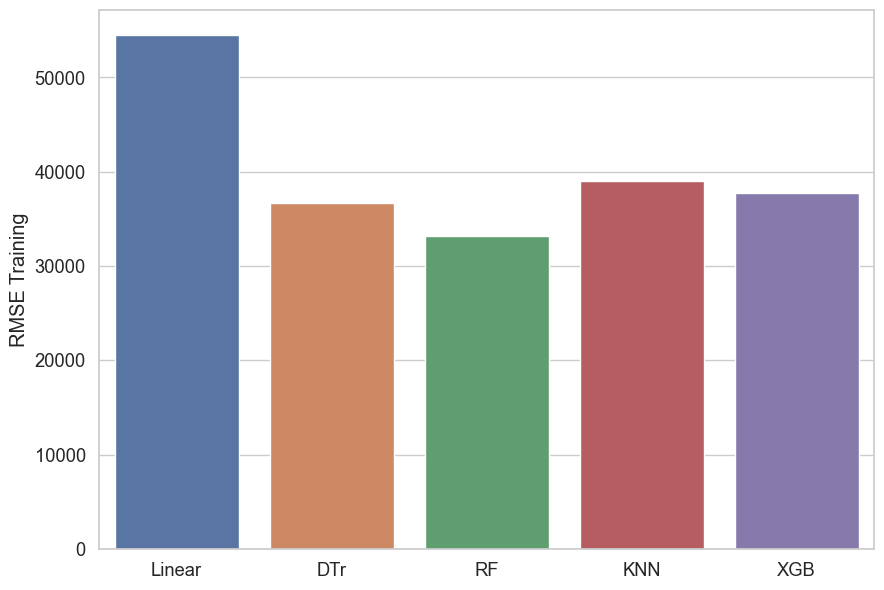

In [82]:
list_scores = [sc_LR,sc_dtree, sc_rf, sc_knn, sc_xgb]
list_predictions = [pred_linreg_all,dtree_predictions, rf_predictions, pred_knn, pred_xgb]
list_regressors = ['Linear','DTr','RF','KNN','XGB']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE Training')
plt.show()

**Linear Regression models gave up high RMSE(but I divide it to make graph balance u can change code to see real RSME of Linear model). Also, XGB, DTR and RF models performed similarly with roughly 30K-40K RMS error in estimation. While RandomForest recorded the lowest RMS error.KNN have the higest error.**

### Moment of Truth

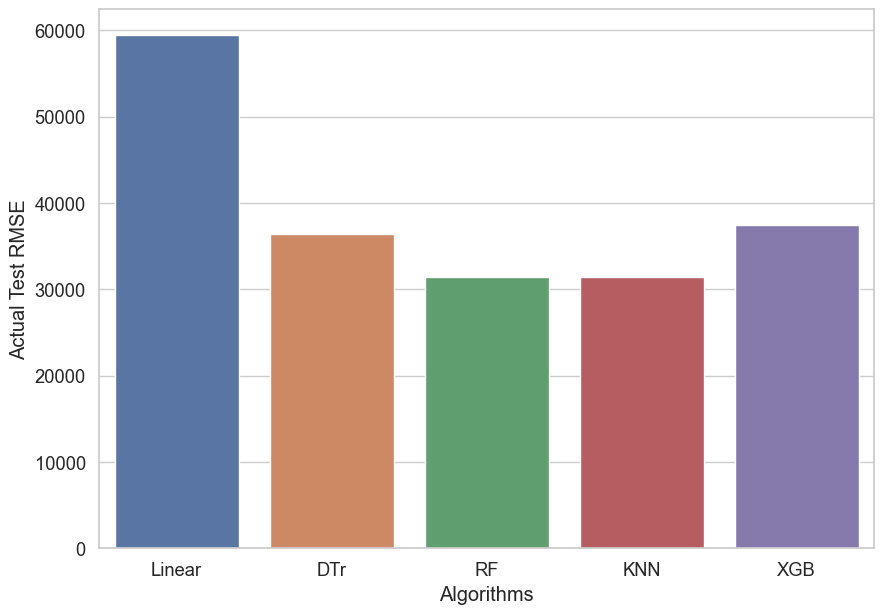

In [83]:
errors = []
for pred in list_predictions:
    errors.append(np.sqrt(mean_squared_error(Y_test, pred)))
    
regressors = ['Linear','DTr','RF','KNN','XGB']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x = regressors, y = errors, ax=ax)
plt.ylabel('Actual Test RMSE')
plt.xlabel('Algorithms')
plt.show()

**Let's compare the overall RMS error secured by models over the testing dataset. RandomForest and KNN outformed all the models in the analysis and secured a rms value less than 40K which means we can actually use the RandomForest and KNN model in estimating the crop production given all the other features.**

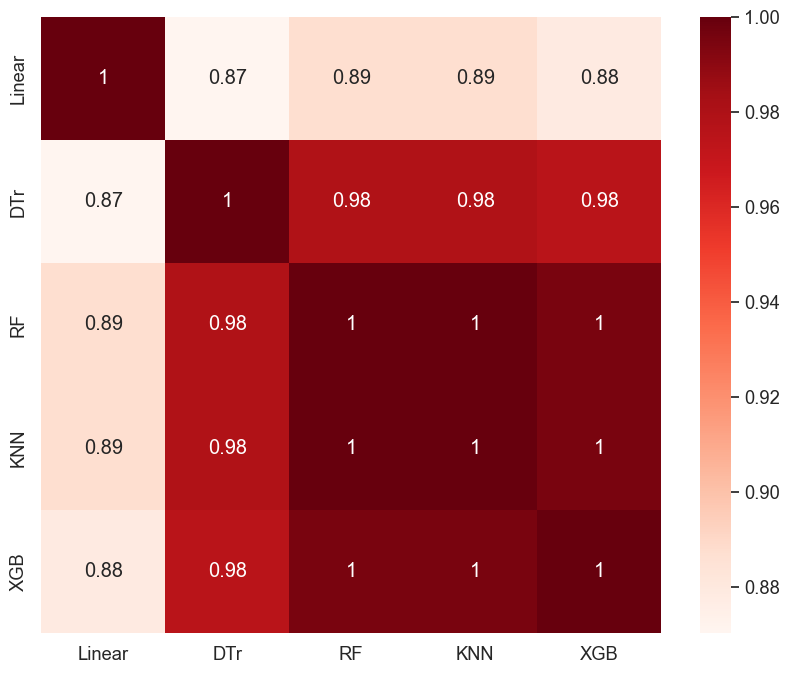

In [84]:
predictions = {'Linear': pred_linreg_all,
               'DTr': dtree_predictions, 'RF': rf_predictions,
               'KNN': pred_knn, 'XGB': pred_xgb}
df_predictions = pd.DataFrame(data=predictions) 

plt.figure(figsize=(10,8))
cor_pred = df_predictions.corr()
sns.heatmap(cor_pred, annot=True, cmap=plt.cm.Reds)
plt.show()

### 8. Svae Model

In [85]:
import pickle

filename = 'crop_yield_predictor_model.pkl'
pickle.dump(best_rf, open(filename, 'wb'))